# r/relationships Analysis

Before the internet, the only peeks into the everyday, non-scripted drama of the strangers around us came through syndicated columns in the newspaper where lovelorn and otherwise distraught souls would write in to Dear Abby or Miss Manners for advice navigating tricky social situations. But times have changed, and like everything else, anonymous advice is available online, 24/7 given by willing strangers. Reddit's [r/relationship forum](https://www.reddit.com/r/relationships/) is probably the premier forum for this, and anonymous users write in by the hundreds every day looking for advice on the harder parts of dealing with other people (and themselves). r/relationships has a bit of notoriety for its [bad advice](http://observer.com/2014/07/this-insane-relationship-advice-subreddit-is-basically-an-online-soap-opera/) and [occasionally bizarre posts](https://twitter.com/redditships?lang=en), but it is also a place where people genuinely do try to help others by dispensing the best advice they can.

It also presents an interesting opportunity for big data analysis and Natural Language Processing (NLP) experimentation. This is mostly due to the presence of tags (which I call *keys*) identifying the age and sex of the various people (*actors*) in each social situation the user is writing in about. In this project, I leverage those keys in an algorithm that builds a structured dataset identifying the age, sex and relation to the poster of each person in the situation. These datasets in turn can then be analyzed in interesting ways and produce insightful visualizations, as well as (hopefully) be used to train some machine-learning models in powerful ways.

Enough with the introductions, let's get to analyzing some big-time, large-scale drama.



## Data Collection and Processing

The objective of this step is to build a script that can use logical statements to build structured data out of post titles from r/relationships. The reason I want to build structured data is I want to be able to analyze and train models with this data in a more interesting way than is usually possible with bag-of-words style approaches. Luckily, there is one significant component of these strings that allows for deconstruction of the string: the key. In the title below, the keys are in bold:

*Is it wrong of me **[25F]** to hold my brother’s **[32M]** childhood behavior against him?*

These keys provide the age and sex of the actors involved, while also providing clues as to relations of those actors to the author (or OP, for original poster). The goal of this script is to use those keys to produce an output like so from the above:

| id | age | sex | relation |
|----|-----|-----|----------|
| 1  | 25  | f   | OP       |
| 2  | 32  | m   | brother  |

With the script below, I am happy to say I figured out a way of doing that with an error rate of 6% (aka ingested titles that threw an error) and an accuracy rate of about 90% (aka modeled the title incorrectly). 

----------------------------
### Data Collection

The data cleaning process is fairly uninteresting but essential so it is included below. I basically use [PRAW](https://praw.readthedocs.io/en/latest/) to scrape post titles, times, IDs, and flair (category) to a SQLite database I store locally. Post text and top comments (when existing) go to text files concurrently. I ran this script once a day or so and picked up ~400 posts on average.

In [1]:
import praw
import pandas as pd
from pandas.io import sql
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy
import datetime
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt

In [2]:
# https://plot.ly/python/big-data-analytics-with-pandas-and-sqlite/
disk_engine  = sqlalchemy.create_engine('sqlite:///relationships.db')

# if you are trying to use this yourself you will need to add your own info below
r = praw.Reddit(username=
                password=
                client_id=
                client_secret=
                user_agent='topPostSnatcher v0.1 by u/reddit2spotify for u/frankhav')

submissions = r.subreddit("relationships").new(limit=1000)

existing_ids = pd.read_sql_query("SELECT id FROM raw_data", disk_engine).values

df = pd.DataFrame()

for sub in submissions:
    ID= sub.id
    flair = sub.link_flair_text
    comments_exist = len(list(sub.comments)) > 0
    if flair not in ['[new]','Updates'] and sub.id not in existing_ids and comments_exist:
        df = df.append(dict(ID= ID,
                       title= sub.title,
                       date= datetime.datetime.fromtimestamp(sub.created),
                       flair= flair
    ), ignore_index=True)

        with open("posts/%s.txt"%ID, "w+") as text_file:
            text_file.write(sub.selftext)

        with open("tcs/%s.txt"%ID, "w+") as text_file:
            text_file.write(sub.comments[0].body)

df.set_index('ID', inplace=True)
df.to_sql('raw_data', disk_engine, if_exists='append')

### Data Processing

Next step is the real meat of the project and involved making some meaningful, structed data out of the titles. To start, I created a large dictionary to generalize the terms used by people when talking about their relationships.

In [19]:
relations_dict = {
    'OP':['i', 'me', "i'm", "i’m", "myself", 'im'],
    'friend':['friend', 'friends'],
    'fiance':['fiance', 'fiancé', 'fiancee', 'fiancée'],
    'female_SO': ['girlfriend', 'gf'],
    'male_SO':  ['boyfriend', 'bf'],
    'ambigous_SO':['so','s.o.', 'partner'],
    'roommate':['roommate','flatmate'],
    'ex':['ex', 'ex-gf', 'ex-girlfriend', 'ex-bf', 'ex-boyfriend', 'ex-bf', 'ex-wife', 'ex-husband'],
    'husband':['husband', 'hubby'],
    'wife':['wife','wifey'],
    'spouse':['spouse'],
    'father':['father','dad'],
    'mother':['mother','mom', 'mum'],
    'parents':['parents'],
    'brother':['brother','bro'],
    'sister':['sister','sis'],
    'ext_fam':['cousin','uncle','aunt','grandfather','grandpa','grandmother','grandma',
               'niece','nephew', 'mil', 'fil','sil','bil'],
    'neighbor':['neighbor', 'neighbour'],
    'colleague':['employee','coworker','boss','manager','supervisor', 'co-worker', 'colleague'],
    'fling':['fwb', 'hookup'],
    'medical':['doctor','therapist'],
    'crush':['crush', 'interest', 'match'],
    'other': ['someone', 'person']
}

weak_relations_dict = {
    'other_m':['guy','dude','man', 'he','him'],
    'other_f':['girl','chick', 'woman', 'she','her'],
    
}

# lazy change to sets for later
for k,v in relations_dict.items():
    relations_dict[k] = set(v)
    
for k,v in weak_relations_dict.items():
    weak_relations_dict[k] = set(v)

### t_dissect()

Next, I wrote the quite long function below, t_dissect(), which processes the string and surmises the relationships indicated within. The basic approach was to strip the data down of special characters, split it into a list of words in the original order, use a powerful and adaptable regex string to identify keys within the list, then use a series of if/then statements to work through and determine each key's relation to the title.

This was an incredibly tricky task that I tried to do with mostly vanilla python and regex. To illustrate some the difficulties, consider the three different ways the following problem could be stated:

- My [34/M] husband is constantly criticizing my [30/F] appearance and it is hurting me. What to do?
- My [30/F] husband [34/M] is constantly criticizing my  appearance and it is hurting me. What to do?
- My husband [34/M] is constantly criticizing my [30/F] appearance and it is hurting me. What to do?

The third example is by far the easiest since the two keys are not close in the string. The first two, and especially the second, are syntactically valid but huge headaches. "My [30/F] husband" fully indicates that 'my' and 'husband' are referring to 30/F and we only know they are not by the presence of the key following the next key at the 4th phrase in the sentence.

One approach would be to try to use the gender of the relation to try to give clues ('son', 'husband' vs 'daughter', 'wife') but there are too many gender-ambigous relations in my relations dictionary for that to be a viable approach. Rather what I do is work backwards through the keys and make a number of assumptions that work pretty well for the most part. The number of if/then trees can be baffling, but it does eventually work out. There are also some lines for a diagnostic mode on the function that just prints out the data at each step of processing, an example of that is in the cell following the function.

In [20]:
def t_dissect(title, diagnose=False):
    if diagnose: print("Original:", '\n', title, '\n',)
    table = str.maketrans({x:' ' for x in list("|\/|()[].?!:,")})
    title = title.translate(table).lower()
    
    # split the title into a list
    title_list = title.split()
    if diagnose: print("Unprocessed list:  ", '\n', title_list, '\n')
        
    # this obnoxiously long code clears out spaces between the gender and sex markers 
    # if there is a space between them
    age=''
    g_index = int()
    g_list = [w for w in title_list if len(w) == 1 and w in list('FfMm')]
    for word in g_list:
            g_index = title_list.index(word)
            if g_index == 0:
                age = title_list[g_index+1]
                title_list[g_index] = word+age
                del title_list[g_index+1]
            elif g_index == title_list[-1]:
                age = title_list[g_index-1]
                title_list[g_index] = word+age
                del title_list[g_index-1]
            else:
                age = title_list[g_index-1]
                if re.search(r'(\d+)', title_list[g_index-1]) is None:
                    age = title_list[g_index+1]
                    title_list[g_index] = word+age
                    del title_list[g_index+1]
                else:
                    title_list[g_index] = word+age
                    del title_list[g_index-1]

    # removes possessives
    for word in title_list:
        if word[-2:] == "’s" or word[-2:] == "'s": title_list[title_list.index(word)] = word[:-2]

    if diagnose: print('Processed list:', '\n', title_list, '\n\n-_-_-_-_-_--_-_-_-_-_-\n')
    # find the keys in the title
    keys =  []
    for word in title_list:
        if re.search(r'\d+(?:,| |\/|)[sMmFf](?!o)|[sMmsFf](?:,| |\/|)\d+', word) is not None:
            keys.append(word)
    if len(keys) == 0:
        return None, None

    # set the duplicate flag to true and extract any duplicate keys
    duped_keys = []
    if len(keys) != len(set(keys)): 
        duped_keys = [item for item, count in Counter(keys).items() if count > 1]
    

    # create an ordered list of actors as they appear in the title
    p_dict = {x:{'age':None,'sex':None,'relation':None} for x in range(len(keys))}
    OP_found = False
    n_keys = len(keys)
    OP_index = None
    if diagnose: print("Keys:", keys, '\n')
        
    for n, key in enumerate(keys[::-1]):
        # shoot for middle if ambiguity in age by OP (40sM -> 45M)
        age_mod = 5 if 's' in key else 0
        
        # pull the age and sex of the person from the key
        p_dict[n]['age'] = int(re.findall(r'(\d+)', key)[0]) + age_mod
        p_dict[n]['sex'] = re.findall(r'([MmFf])', key)[0]
        
       # get the index of the age/sex key in question and save the two elements on either side of it (if possible)
        name_index = title_list.index(key)

        before, after = set(), set()
        for x in [1,2]:
            if (name_index - x) >= 0:
                before.add(title_list[name_index-x].lower())
            try:
                if x == 1:
                    after.add(title_list[name_index+x].lower())
            except: continue
        
        def find_relation(before, after, r_dict, OP_found):
            if 'my' in before: my_flag = True
            else: my_flag = False

            # loop through both the before and after words list and identify what categories are identified
            before_relation, after_relation = None, None
            for k,v in r_dict.items():
                if len(v & before) > 0:
                    before_relation = k
                    continue

                if len(v & after) > 0:
                    after_relation = k
                    continue
            
            # decide on a relation
            relation = 'Unk'
            
            # if the key is adjacent to "my"... 
            if my_flag:
                # and there are no other relations surrounding, assume OP
                if before_relation is None and after_relation is None:
                    relation, OP_found = 'OP', True              
                
                # and there is a relation in the before group, assume that relation
                elif after_relation is None and before_relation is not None:
                    relation = before_relation
                    OP_found = True if relation == 'OP' else False
                
                # and there is a relation in the after group and OP has NOT been found, assume OP
                elif before_relation is None and after_relation is not None and OP_found == False:
                    relation, OP_found = 'OP', True  
                        
                # otherwise assume the after relation
                elif before_relation is None:
                    relation = after_relation
                    OP_found = True if relation == 'OP' else False
                
                # if none of these conditions match ¯\_(ツ)_/¯ assume before relation 
                elif OP_found is False:
                    relation = before_relation
                    OP_found = True if relation == 'OP' else False
                    
                # unless OP is found, in which case assume after
                else:
                    relation = after_relation
                    if relation == 'OP': OP_found = True
                
            # if the key is NOT adjacent to "my"...         
            if not my_flag:
                if before_relation is not None: 
                    relation = before_relation
                    OP_found = True if relation == "OP" else False
                elif after_relation == 'OP': 
                    relation = before_relation
                    OP_found = True if relation == 'OP' else False
                else: 
                    relation = before_relation
                    OP_found = True if relation == 'OP' else False
            
            if n == len(keys) and OP_found is False:
                relation, OP_found = 'OP', True
            
            return relation, OP_found

        if diagnose: print(key, " adjacent: ", before, after)
        
        # if there is only one key in the title, assume OP. Easy!
        if len(keys) == 1:
            relation = 'OP'
        
        # call the above function to find the relation from the primary relations dict
        else:
            relation, OP_found = find_relation(before, after, relations_dict, OP_found)
        
        # or the secondary dict if necessary
        if relation is None:
            relation, OP_found = find_relation(before, after, weak_relations_dict, OP_found)
        
        # final try: use the gender marker of the key to make a vague guess
        if relation is None:
            if p_dict[n]['sex'] == 'f': relation = 'other_f'
            elif p_dict[n]['sex'] == 'm': relation = 'other_m'
            else: relation = 'Unk'
            
        # if the key is duped, wipe the key just examined from the string so it is not considered in subsequent loops
        if key in duped_keys:
            del title_list[name_index]
            
        if relation == 'OP': OP_index = n
        p_dict[n]['relation'] = relation
    
    if diagnose==True: 
        print('\n Dictionary result: ')
        for k,v in p_dict.items(): print(k,v,)
        print('\n', '\n')
    
    if diagnose == False:
        return p_dict, OP_index

Below, consider the step-by-step output of this four actor doozy: *"My [29F] dad [55M] forced my sister [16F] to have a pregnancy test and a urine sample for drugs when her boyfriend [16-17M] dropped her at home last Friday."*

In [21]:
t_dissect("My [29F] dad [55M] forced my sister [16F] to have a pregnancy test and a urine sample for drugs when her boyfriend [16-17M] dropped her at home last Friday.", diagnose=True)

Original: 
 My [29F] dad [55M] forced my sister [16F] to have a pregnancy test and a urine sample for drugs when her boyfriend [16-17M] dropped her at home last Friday. 

Unprocessed list:   
 ['my', '29f', 'dad', '55m', 'forced', 'my', 'sister', '16f', 'to', 'have', 'a', 'pregnancy', 'test', 'and', 'a', 'urine', 'sample', 'for', 'drugs', 'when', 'her', 'boyfriend', '16-17m', 'dropped', 'her', 'at', 'home', 'last', 'friday'] 

Processed list: 
 ['my', '29f', 'dad', '55m', 'forced', 'my', 'sister', '16f', 'to', 'have', 'a', 'pregnancy', 'test', 'and', 'a', 'urine', 'sample', 'for', 'drugs', 'when', 'her', 'boyfriend', '16-17m', 'dropped', 'her', 'at', 'home', 'last', 'friday'] 

-_-_-_-_-_--_-_-_-_-_-

Keys: ['29f', '55m', '16f', '16-17m'] 

16-17m  adjacent:  {'her', 'boyfriend'} {'dropped'}
16f  adjacent:  {'sister', 'my'} {'to'}
55m  adjacent:  {'29f', 'dad'} {'forced'}
29f  adjacent:  {'my'} {'dad'}

 Dictionary result: 
0 {'age': 16, 'sex': 'm', 'relation': 'male_SO'}
1 {'age': 16,

Aced it! However, you may notice that the 16 year old boyfriend in this title is referenced as the SO (significant other) of the OP, which isn't quite accurate. Second party actors like that are one of the limitations of the current function, along with these other ones I have observed:

* **Second degree relations**: As discussed above, this isn't wrong, but it could lead to misinterpretations of data further down the road. Take this title for instance: *I [23F] am concerned that my best friend’s [23F] boyfriend [29M] has a secret son [~4 months]*. All actors get correctly identified, but the "boyfriend" in this case is the boyfriend of the best friend, not OP. Nonetheless he gets thrown in the OP relation along with all the other boyfriends. Not a problem really, but should be kept in mind.

* **Actor ambiguity**: Take for example this title: *"Boyfriend [20] broke up with me [18F] yesterday after almost a year. He is everything to me. I feel so lost."*. It is fairly obvious the actors involved to us, but since the author tagged "Boyfriend [20]", the gender is given by the relation, not the key. Currently one of the big weaknesses of this script is the lack of interaction between the identification of keys and the identifications of the relations, though this would be an easy target for improvement later on.

* **regex artifacts**: The regex expression works almost flawlessly with a few exceptions. For example, in *My [26F] boyfriend [27M] of 8M has been working[...]*, 8M (eight months) gets picked up as a key, d'oh!

* **Non-binary and trans keys**: I'm not trying to avoid this or anything but it is functionality I have not figured out how to implement yet. Specifically rewriting the regex expression to catch "MtF" "FtM" etc is a pretty core change, but I would like to get to it soon.

---------------------------

## Assessing the Script

Below, I pull the 2,938 titles I've been scraping from the subreddit for a couple weeks and run t_dissect on them, then assign the results to a pandas dataframe.

In [22]:
error_list = []

disk_engine  = sqlalchemy.create_engine('sqlite:///relationships.db')
titles = pd.read_sql_query("SELECT title FROM raw_data", disk_engine).values

test_df = pd.DataFrame(columns=['title', 'n_actors'])
for title in titles:
    try:
        p_dict, OP_index = t_dissect(title[0])
        if p_dict:
            append_dict = dict(title= title,
                               n_actors=len(p_dict),
                              OP_age= p_dict.get(OP_index)['age'],
                              OP_sex= p_dict.get(OP_index)['sex'])
            del p_dict[OP_index]

            flat_dict = {}
            for x, v in enumerate(p_dict.values()):
                new_keys = ['P'+str(x+1)+'_'+y for y in v.keys()]
                flat_dict.update(dict(zip(new_keys, v.values())))

            append_dict.update(flat_dict)

            test_df = test_df.append(append_dict, ignore_index=True)
    except:
        error_list.append(title)

How'd it do?

In [23]:
print("Titles processed: ", len(titles))
print("Errors thrown   : ", len(error_list))
print("Error rate      : ", round(len(error_list) / len(titles), 4)*100)

Titles processed:  3142
Errors thrown   :  177
Error rate      :  5.63


Something upset the script in 177 of the 3142 titles, or just under 6%. Note that errors also occurred when OP could not be identified. Overall, this is pretty good given the range of titles gathered from an "in-the-wild" NLP environment. 

However, error rate is only one question, and not a very important one - the real question is the accuracy of the script. Using very conservative standards for what constitutes "valid", I manually validated a random set of 100 of the results in [this Google Sheet](https://docs.google.com/spreadsheets/d/155OywYmF6nHHqjTvLkIiij-OQ2YLw6kMJZjBfCrxztw/edit?usp=sharing) and found an accuracy of **89%** of the titles ingested. 

--------------

In [24]:
r = np.random.randint(1, (len(test_df)-500))
test_df.iloc[r:r+100].to_csv('Aug24_validation.csv')

One persistent problem I am facing with this script is that it is quite aggressive in assuming author and can sometimes mistake more than one OP despite my best efforts against that. OP ends up being identified for more than one actor, which is obviously incorrect, in 120 of the titles. Since I know this is incorrect, I chose to drop these titles.

In [25]:
len(test_df.query("P1_relation =='OP' or P2_relation == 'OP' or P3_relation == 'OP'"))

120

In [26]:
test_df = test_df.query("P1_relation !='OP' and P2_relation != 'OP' and P3_relation != 'OP'")

## What to do with this data?

Well, what's it look like?

In [27]:
test_df.head()

,title,n_actors,OP_age,OP_sex,P1_age,P1_relation,P1_sex,P2_age,P2_relation,P2_sex,P3_age,P3_relation,P3_sex,P4_age,P4_relation,P4_sex,P5_age,P5_relation,P5_sex
0,[[25f] my romantic relationship is crumbling b...,1,25.0,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[I [19M] think it's time to stop being friends...,2,19.0,m,18.0,friend,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[I am losing myself [23M] in this relationship...,2,23.0,m,23.0,ambigous_SO,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[I'm [25/F] going ""on a break"" with my boyfrie...",2,25.0,f,23.0,male_SO,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[I [19F] am ridiculously jealous of a friend [...,2,19.0,f,21.0,male_SO,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There's quite a bit you can do with that. I am planning on building up some cool visualizations and whatnot for the next part of this project, then doing some further bag-of-words and TF-IDF processing to really make things interesting.

I will need to develop some tools (or reconfigure my dataframe assignment code) to reflect the quasi-3d nature of the data. By that I mean aside from OP, the other actors in the title are placed according to the syntax of the sentence. As seen below, the majority of titles had only two actors identified, so querying P1 as the primary actor makes sense. In the future I will write functions to handle the dimensionality of the data more completely.

In [28]:
test_df.n_actors.value_counts()

2    1885
1     343
3     194
4      20
6       3
5       1
Name: n_actors, dtype: int64

For now though, the data generated can be queried using standard pandas/SQL methods to answer questions like: Who are females writing about most frequently?

In [29]:
test_df.query("OP_sex == 'f'")['P1_relation'].value_counts()

male_SO        398
other_m        180
friend         130
husband         55
mother          54
ambigous_SO     50
ex              47
other_f         46
colleague       32
father          23
brother         22
fiance          21
female_SO       19
sister          17
roommate        16
ext_fam         15
parents         11
other           10
crush            9
fling            8
neighbor         4
wife             2
medical          1
Name: P1_relation, dtype: int64

What is the average age of the girlfriends of 22 year old males?

In [30]:
test_df.query("OP_sex == 'm' and OP_age == 22 and P1_relation == 'female_SO'").P1_age.mean()

21.68421052631579

What's the median age of men writing about mothers vs women writing about mothers? Note I say mothers here rather than their mothers because of the second-degree relation problem mentioned above.

In [33]:
men = test_df.query("OP_sex == 'm' and P1_relation == 'mother'").OP_age.median()
women = test_df.query("OP_sex == 'f' and P1_relation == 'mother'").OP_age.median()

print("Men: ", men)
print("Women: ", women)


Men:  20.5
Women:  23.5


Finally, just a taste of interesting data visualizations to come. For women in their 20s, what is the distribution of age differences between themselves and male SOs mentioned in their posts?

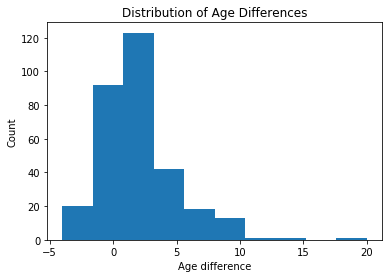

In [32]:
query = test_df.query("OP_age >= 20 and OP_age < 30 and P1_relation == 'male_SO'")
dist = query.P1_age - query.OP_age

plt.hist(dist)
plt.xlabel("Age difference")
plt.ylabel("Count")
plt.title("Distribution of Age Differences")

plt.show()

As one might notice from everyday observations, women tend to date men older than them and that is reflected in the skewed data.

## Onward!

Now that the tough stuff is taken care of, I am excited to do some better visualizations and also test training some models on this data. I'll get around to that soon with another blog post to look out for soon.